In [31]:
import os

input_dir = "../Training Data/AllImages"
target_dir = "../Training Data/AllMasks/"

input_test_dir = "../Test Data/AllImages"
target_test_dir = "../Test Data/AllMasks/"
img_size = (512, 512)
num_classes = 2
batch_size = 16

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

input_test_img_paths = sorted(
    [
        os.path.join(input_test_dir, fname)
        for fname in os.listdir(input_test_dir)
        if fname.endswith(".png")
    ]
)
target_test_img_paths = sorted(
    [
        os.path.join(target_test_dir, fname)
        for fname in os.listdir(target_test_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of training/validation samples:", len(input_img_paths))
print("Number of test samples:", len(input_test_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)


Number of training/validation samples: 2341
Number of test samples: 331
../Training Data/AllImages/0.png | ../Training Data/AllMasks/0.png
../Training Data/AllImages/1.png | ../Training Data/AllMasks/1.png
../Training Data/AllImages/10.png | ../Training Data/AllMasks/10.png
../Training Data/AllImages/100.png | ../Training Data/AllMasks/100.png
../Training Data/AllImages/1000.png | ../Training Data/AllMasks/1000.png
../Training Data/AllImages/1001.png | ../Training Data/AllMasks/1001.png
../Training Data/AllImages/1002.png | ../Training Data/AllMasks/1002.png
../Training Data/AllImages/1003.png | ../Training Data/AllMasks/1003.png
../Training Data/AllImages/1004.png | ../Training Data/AllMasks/1004.png
../Training Data/AllImages/1005.png | ../Training Data/AllMasks/1005.png


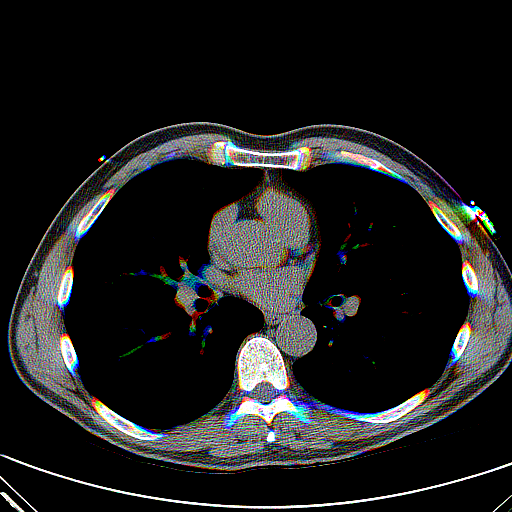

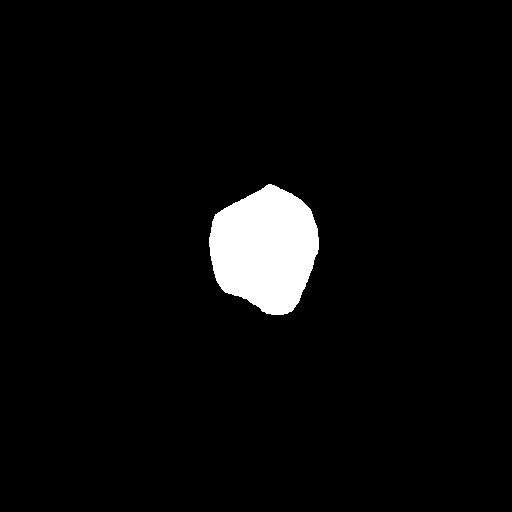

In [32]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
#img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
img = load_img(target_img_paths[9])
display(img)


In [33]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class EAT(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 0,255 Divide by 255 to make them 0, 1:
            y[j] =  np.floor_divide(y[j],255)
        return x, y


In [34]:
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
#model.summary()


In [35]:
import random

# Split our img paths into a training and a validation set
val_samples = 200
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = EAT(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = EAT(batch_size, img_size, val_input_img_paths, val_target_img_paths)


In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
from keras import backend as kerasb

import tensorflow as tf
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

## Hyperparameters
lr = 1e-4

opt = keras.optimizers.Adam(lr)
metrics = ['acc',iou]
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=metrics)

callbacks = [
    ModelCheckpoint("unet_EAT.hdf5"),
    CSVLogger("data.csv"),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4),
    TensorBoard(),
    EarlyStopping(monitor='loss', patience=10, restore_best_weights=False)
]

# Train the model, doing validation at the end of each epoch.
epochs = 40
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/40
133/133 [==============================] - 122s 884ms/step - loss: 0.1915 - acc: 0.9549 - iou: 0.0396 - val_loss: 0.4203 - val_acc: 1.0000 - val_iou: 0.0411 - lr: 1.0000e-04
Epoch 2/40
133/133 [==============================] - 117s 880ms/step - loss: 0.0660 - acc: 0.9633 - iou: 0.0396 - val_loss: 0.4839 - val_acc: 1.0000 - val_iou: 0.0411 - lr: 1.0000e-04
Epoch 3/40
133/133 [==============================] - 119s 894ms/step - loss: 0.0493 - acc: 0.9621 - iou: 0.0396 - val_loss: 0.2861 - val_acc: 1.0000 - val_iou: 0.0411 - lr: 1.0000e-04
Epoch 4/40
133/133 [==============================] - 117s 880ms/step - loss: 0.0404 - acc: 0.9625 - iou: 0.0396 - val_loss: 0.0831 - val_acc: 0.9800 - val_iou: 0.0411 - lr: 1.0000e-04
Epoch 5/40
133/133 [==============================] - 118s 885ms/step - loss: 0.0330 - acc: 0.9618 - iou: 0.0396 - val_loss: 0.0471 - val_acc: 0.9753 - val_iou: 0.0411 - lr: 1.0000e-04
Epoch 6/40
133/133 [==============================] - 118s 886ms/step - los

KeyboardInterrupt: 

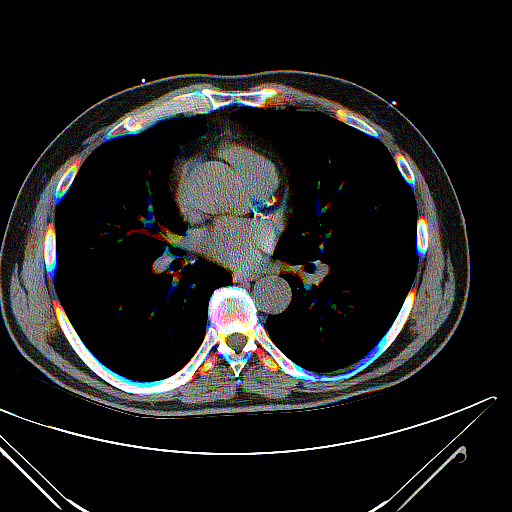

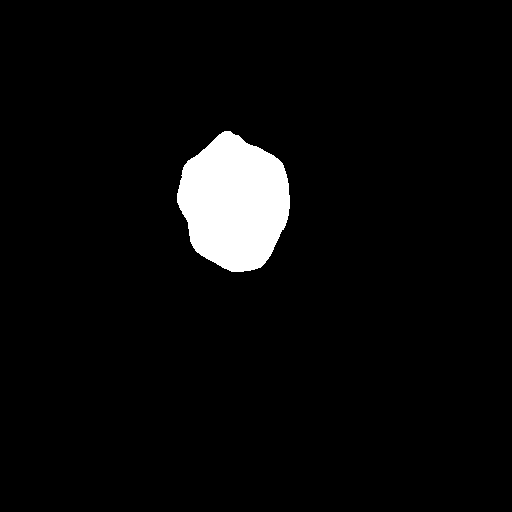

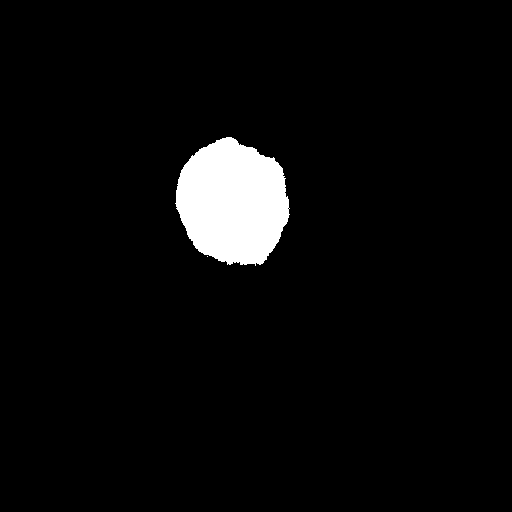

In [37]:
# Generate predictions for all images in the validation set
# Instantiate data Sequences for each split
val_gen = EAT(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

def display_mask(src, i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(src[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(val_preds,i)  # Note that the model only sees inputs at 150x150.

In [44]:
import sys
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
import skimage.io as io
import skimage.transform as trans
import matplotlib


def saveResults(results,save_path):
    shape = results.shape
    for i in range(0,shape[0]):
        mask = np.argmax(results[i], axis=-1)
        mask = np.expand_dims(mask, axis=-1)
        img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
        imRGB = np.zeros((img_size[0],img_size[1],3))
        imArray = np.asarray(img)
        imRGB[:,:,0] = imArray
        imRGB[:,:,1] = imArray
        imRGB[:,:,2] = imArray
        matplotlib.image.imsave(os.path.join(save_path,"%d.png"%i), imRGB.astype(np.uint8))


# Generate predictions for all images in the test set
# Instantiate data Sequences for each split
model.load_weights("unet_EAT_good_10epochs.hdf5")
test_gen = EAT(batch_size, img_size, input_test_img_paths, target_test_img_paths)
test_preds = model.predict(test_gen)        
saveResults(test_preds, "../Test Data/AllOutputMasks")